<h1> DSCI_100 Project Final Report </h1>

Group: 002-034
<p> Members: Tulsi Bhandari, Emily Choi, Lila El-Sakhawy, Kimberly Horng </p>

<h3> Introduction </h3>

<h4> Background Information </h4>
A UBC Computer Science research group, led by Frank Wood, is collecting data regarding the ways in which different people play video games. The research group is using a Minecraft server that links to an external site in order to record the actions of each player as they use the server. The research group must make accommodations to manage the attracted players, ensuring they have sufficient resources such as software liscences and server hardware, while finding ways to target their recruitment efforts. The following investigation asks the predictive question, <strong> Can age and average playing session time predict the total time spent playing Minecraft? </strong> and will address the question using a K-nearest neighbors regression predictive model.

<h4> Data Description </h4>
players_data (from players.csv): variables:

- experience: a character variable indicating the experience level of each player (outputs "Amateur", "Beginner", "Regular", "Veteran", or "Pro")
- subscribe: a logical variable indicating whether each player is subscribed to a game-related newsletter (outputs either "TRUE" or "FALSE")
- hashedEmail: a character variable containing information related to the players' emails
- played_hours: a double variable indicating how long each player used Minecraft in hours
- name: a character variable denoting each player's name
- gender: a character variable denoting each player's gender
- Age: a double variable denoting each player's age (as a whole number) number of observations: 196 (data was collected from 196 players)

Summary Statistics:

Subscription to newsletter

- "TRUE" = 144
- "FALSE" = 52

Age

- minimum age = 8 years
- maximum age = 50 years
- mean age = 20.53 years
- median = 19 years
- standard deviation = 6.174 years

Total Time Spent Playing Minecraft

- minimum time = 0.000 hours
- maximum time = 223.100 hours
- mean time = 8.002 hours
- median = 0.100 hours
- standard deviation = 28.357 hours

It seems that this data set is tidy. I cannot predict any issues that may arise when analyzing the data in this data set.


sessions_data (from sessions.csv): variables:

- hashedEmail: a character variable containing information related to the players' emails
- start_time: a character variable denoting when a player started to play Minecraft (formatted as the date in DD/MM/YYYY followed by the time as HH:MM)
- end_time: a character variable denoting the time a player stopped playing Minecraft (formatted the same as start_time)
- original_start_time: a double character denoting the players' start times in UNIX time
- original_end_time: a double character denoting the players' end times in UNIX time number of observations: 1535

Summary Statistics: Original Start Time

- min = 1.712e+12 seconds
- max = 1.727e+12 seconds
- mean = 1.719e+12 seconds
- median = 1.719e+12 seconds
- standard deviation = 3.553e+9 seconds

Original End Time

- min = 1.712e+12 seconds
- max = 1.727e+12 seconds
- mean = 1.719e+12 seconds
- median = 1.719e+12 seconds
- standard deviation = 3.557e+9 seconds
- NA's = 2

The data set appears to be untidy since the start_time and end_time variables contain both a date and a time. To make the data tidy, the dates and times will need to be separated into different columns (columns for day, month, year, hour and minutes for start and end times). The original_start_time and original_end_time variables lack the necessary precision so will likely be irrelevant to the data analysis.

In [1]:
# load these libraries to use for accessing and wrangling the data later, as well as for constructing visualizations and the predictive model. This also sets the seed to ensure reproducibility.
library(tidyverse)
library(repr)
library(lubridate)
library(dplyr)
library(tidymodels)
set.seed(3762)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

In [2]:
# The following code will be used to read the data into R. The URLs for the raw data files were used to ensure the method of reading the data in is reproducible.
players_url <- "https://raw.githubusercontent.com/lilael-sakhawy/dsci_100_individual_project_planning_stage/refs/heads/main/players.csv"
sessions_url <- "https://raw.githubusercontent.com/lilael-sakhawy/dsci_100_individual_project_planning_stage/refs/heads/main/sessions.csv"

players_data <- read_csv(players_url)
sessions_data <- read_csv(sessions_url)

head(players_data)
head(sessions_data)

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17


hashedEmail,start_time,end_time,original_start_time,original_end_time
<chr>,<chr>,<chr>,<dbl>,<dbl>
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,30/06/2024 18:12,30/06/2024 18:24,1.71977e+12,1.71977e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,17/06/2024 23:33,17/06/2024 23:46,1.71867e+12,1.71867e+12
f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3398304c7ae42581fdc,25/07/2024 17:34,25/07/2024 17:57,1.72193e+12,1.72193e+12
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,25/07/2024 03:22,25/07/2024 03:58,1.72188e+12,1.72188e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,25/05/2024 16:01,25/05/2024 16:12,1.71665e+12,1.71665e+12
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,23/06/2024 15:08,23/06/2024 17:10,1.71916e+12,1.71916e+12


In [3]:
# the following code will be used to transform sessions_data into a tidy format
sessions_tidy <- sessions_data |>
    separate(col = start_time, 
            into = c("start_date", "start_time"),
            sep = " ") |>
    separate(col = end_time, 
             into = c("end_date", "end_time"),
            sep = " ") |>
    separate(col = start_date, 
             into = c("start_day", "start_month", "start_year"),
             sep = "/") |>
    separate(col = end_date, 
             into = c("end_day", "end_month", "end_year"),
             sep = "/") |>
    separate(col = start_time,
             into = c("start_hour", "start_minutes"),
             sep = ":") |>
    separate(col = end_time,
             into = c("end_hour", "end_minutes"),
             sep = ":")
head(sessions_tidy)

hashedEmail,start_day,start_month,start_year,start_hour,start_minutes,end_day,end_month,end_year,end_hour,end_minutes,original_start_time,original_end_time
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,30,06,2024,18,12,30,06,2024,18,24,1.71977e+12,1.71977e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,17,06,2024,23,33,17,06,2024,23,46,1.71867e+12,1.71867e+12
f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3398304c7ae42581fdc,25,07,2024,17,34,25,07,2024,17,57,1.72193e+12,1.72193e+12
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,25,07,2024,03,22,25,07,2024,03,58,1.72188e+12,1.72188e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,25,05,2024,16,01,25,05,2024,16,12,1.71665e+12,1.71665e+12
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,23,06,2024,15,08,23,06,2024,17,10,1.71916e+12,1.71916e+12


In [4]:
# code to split the data into a training set (70%) and a testing set (30%), since only the training set should be used in the exploratory analysis
players_split <- initial_split(players_data, prop = 0.70, strata = played_hours)
players_training <- training(players_split)
players_testing <- testing(players_split)

# code to split sessions_data into a training set and a testing set
sessions_split <- initial_split(sessions_data, prop = 0.70)
sessions_training <- training(sessions_split)
sessions_testing <- testing(sessions_split)

In [5]:
# the following code will be used to compute the mean for quantitative variables in players_data
players_means_training <- players_training |>
    select(played_hours,Age) |>
    summarize(mean_time = mean(played_hours), mean_Age = mean(Age, na.rm = TRUE))
players_means_training 

mean_time,mean_Age
<dbl>,<dbl>
8.002206,20.53333


In [6]:
# the code below finds the summary statistics for each training set
players_summary_training <- summary(players_training)
players_summary_training
sessions_summary_training<- summary(sessions_training)
sessions_summary_training

  experience        subscribe       hashedEmail         played_hours    
 Length:136         Mode :logical   Length:136         Min.   :  0.000  
 Class :character   FALSE:35        Class :character   1st Qu.:  0.000  
 Mode  :character   TRUE :101       Mode  :character   Median :  0.100  
                                                       Mean   :  8.002  
                                                       3rd Qu.:  0.600  
                                                       Max.   :223.100  
                                                                        
     name              gender               Age       
 Length:136         Length:136         Min.   : 8.00  
 Class :character   Class :character   1st Qu.:17.00  
 Mode  :character   Mode  :character   Median :19.00  
                                       Mean   :20.53  
                                       3rd Qu.:22.00  
                                       Max.   :50.00  
                               

 hashedEmail         start_time          end_time         original_start_time
 Length:1074        Length:1074        Length:1074        Min.   :1.712e+12  
 Class :character   Class :character   Class :character   1st Qu.:1.716e+12  
 Mode  :character   Mode  :character   Mode  :character   Median :1.719e+12  
                                                          Mean   :1.719e+12  
                                                          3rd Qu.:1.722e+12  
                                                          Max.   :1.727e+12  
                                                                             
 original_end_time  
 Min.   :1.712e+12  
 1st Qu.:1.716e+12  
 Median :1.719e+12  
 Mean   :1.719e+12  
 3rd Qu.:1.722e+12  
 Max.   :1.727e+12  
 NA's   :2          

In [7]:
sd_players_age_training <- sd(players_training$Age, na.rm = TRUE)
sd_players_age_training
sd_players_time_training <- sd(players_training$played_hours, na.rm = TRUE)
sd_players_time_training
sd_original_start_training <- sd(sessions_training$original_start_time, na.rm = TRUE)
sd_original_end_training <- sd(sessions_training$original_end_time, na.rm = TRUE)
sd_original_start_training
sd_original_end_training

[1] 6.564036

[1] 33.78892

[1] 3541851582

[1] 3534545649

<h3> Exploratory Visualizations </h3>

**Figure 1: Scatterplot of The Total Time Spent Playing Minecraft by Each Player and their Age**

Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_point()`).”


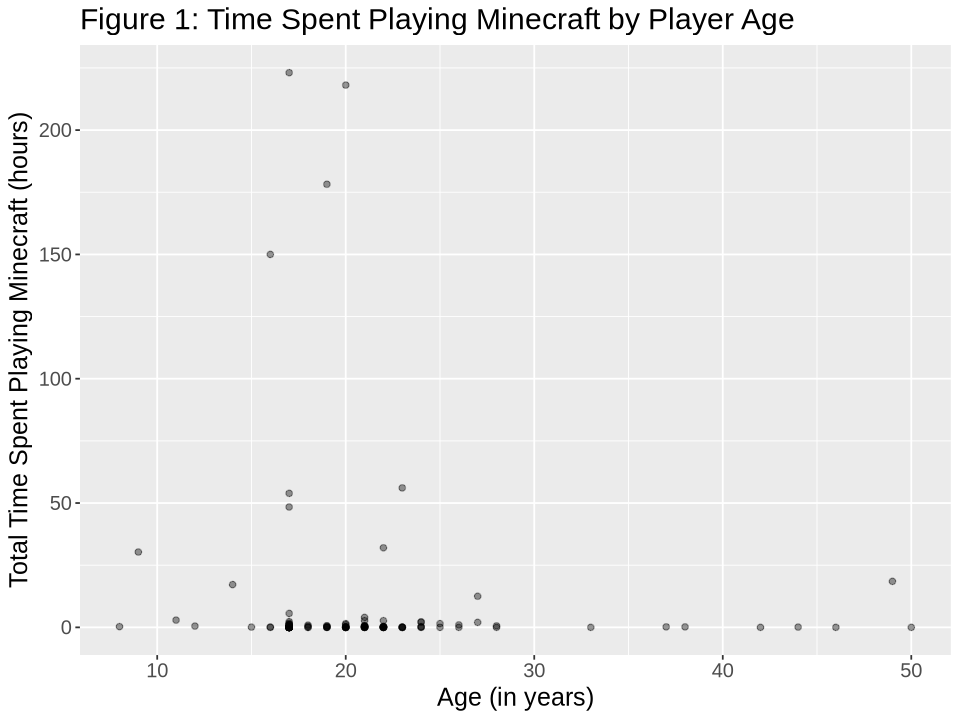

In [8]:
players_training <- mutate(players_training, Age = Age, na.rm = TRUE)
age_effect_plot <- ggplot(players_training, aes(x = Age, y = played_hours)) + 
geom_point(alpha = 0.4) + 
labs(x = "Age (in years)", y = "Total Time Spent Playing Minecraft (hours)", title = "Figure 1: Time Spent Playing Minecraft by Player Age") + 
theme(text = element_text(size = 15))
options(repr.plot.height = 6, repr.plot.width = 8)
age_effect_plot

This visualization hints that players around 15-27 years of age may have spent the most time in total playing Minecraft. It can also be seen that the majority of participants fell within this age range which may influence this interpretation. This visualization may indicate that age could influence the total time spent playing Minecraft.

**Figure 2: Scatterplot of Average Playing Session Time vs The Total Time Spent Playing Minecraft for Each Player**

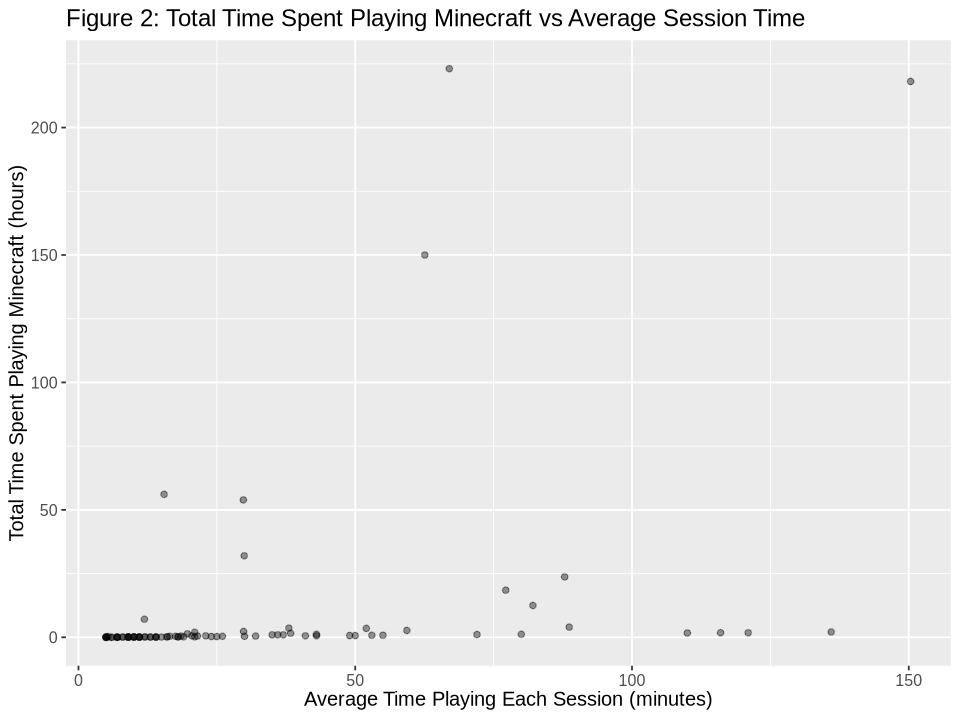

In [9]:
# this code mutates sessions_data to include the time spent playing Minecraft per session
sessions_mutate <- sessions_data |>
    mutate(start_date_time = dmy_hm(start_time), 
           end_date_time = dmy_hm(end_time), 
           session_time = as.numeric(difftime(end_date_time, start_date_time, units = "mins")))

# this calculates the average session time per player 
sessions_average <- sessions_mutate |>
    group_by(hashedEmail) |>
    summarize(session_average = mean(session_time, na.rm = TRUE))

# the data sets should be combined and then split into training and testing sets to make the exploratory visualization
combined_data <- sessions_average |>
    inner_join(players_data, by = "hashedEmail")

combined_split <- initial_split(combined_data, prop = 0.70) 
combined_training <- training(combined_split) |>
    drop_na()
combined_testing <- testing(combined_split) |>
    drop_na()

avg_session_vs_total <- ggplot(combined_training, aes(x = session_average, y = played_hours)) + 
geom_point(alpha = 0.4) + 
labs(x = "Average Time Playing Each Session (minutes)", y = "Total Time Spent Playing Minecraft (hours)", title = "Figure 2: Total Time Spent Playing Minecraft vs Average Session Time") + 
theme(text = element_text(size = 12)) 
options(repr.plot.height = 6, repr.plot.width = 8)
avg_session_vs_total

From the above visualization, it can be seen that there seems to be no clear relationship between the average time spent each session playing Minecraft and the total time spent playing the game. Perhaps the use of average session time as a predictor variable will decrease the accuracy of the predictive model. It may be necessary to remove the average session time as a predictor variable, although its use as a predictor can be evaluated when constructing the predictive model.

**Figure 3: Scatterplot of the Average Playing Session Time for Each Player Based on Age**

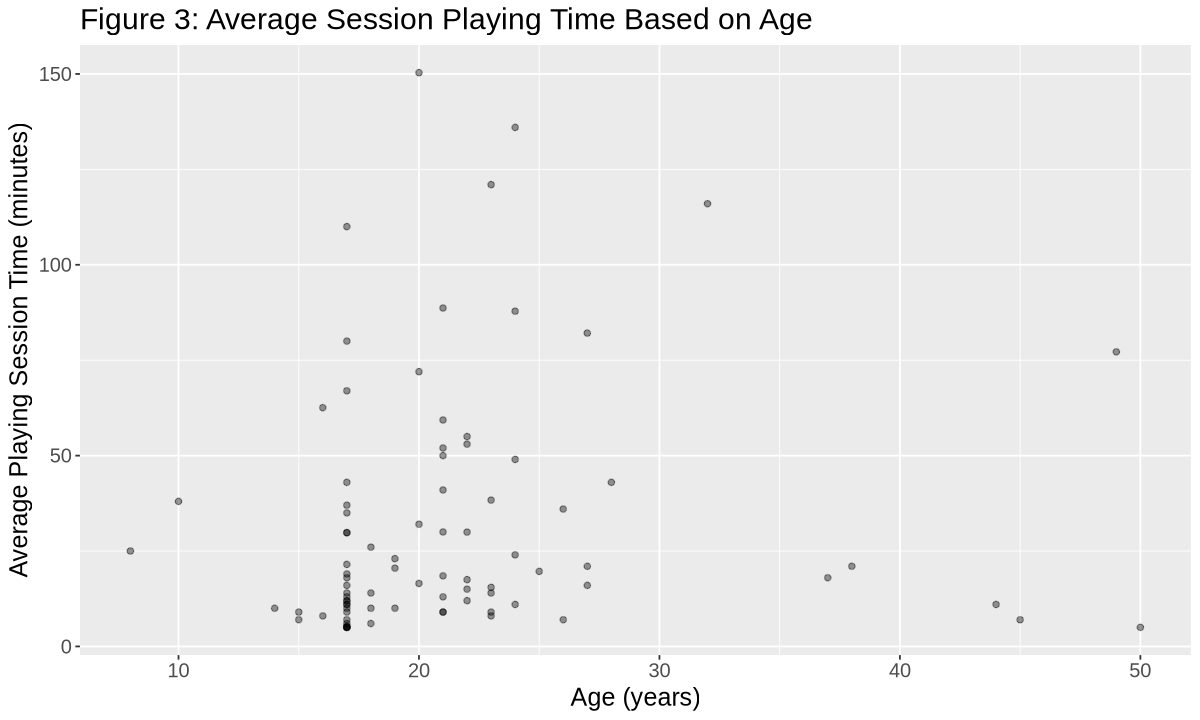

In [10]:
options(repr.plot.height = 6, repr.plot.width = 10)
age_exp_vs_time <- ggplot(combined_training, aes(x = Age, y = session_average)) + 
geom_point(alpha = 0.4) + 
labs(x = "Age (years)", y = "Average Playing Session Time (minutes)", title = "Figure 3: Average Session Playing Time Based on Age") + 
theme(text = element_text(size = 15))
age_exp_vs_time

It can be seen from the visualization that the highest average playing session times were achieved by participants around 15-32 years of age, with the longest average playing session time belonging to a 20-year-old participant. This may be due in part to the fact that many of the participants fell within this age range, alrhough there is a possibility that age and average playing session length are related. 

<h3> Methods and Results </h3>

To answer the specified predictive question, it will be necessary to construct a predictive model for the data. Since the response variable selected is the total amount of time spent playing Minecraft, which is numerical, a regression model would be most appropriate. Linear regression could work if the assumption is made that there will be a linear relationship between the predictors and the response variable. Based on the visualizations above, it seems like this will be unlikely, so linear regression will be avoided. This model may be able to predict the total number of hours spent playing Minecraft, but since it is not linear regression, it will be difficult to extrapolate the data or to make predictions based on observations outside of the range of collected data. The K value will be selected through the use of 5-fold cross-validation, choosing the K value that yields the lowest RMSE. When establishing the model, the data will be split into a training and testing set (with a 70% to 30% proportion), and the training set will be used in cross-validation to select K and also to create a workflow. The data has already been split in above, since the training data set was most appropriate to use when generating the exploratory visualizations. The workflow below will be used to predict the total time spent playing Minecraft for the testing set and the effectiveness of the predictive model can then be evaluated. 

In [11]:
head(combined_training) # the table was recalled for easier reference

hashedEmail,session_average,experience,subscribe,played_hours,name,gender,Age
<chr>,<dbl>,<chr>,<lgl>,<dbl>,<chr>,<chr>,<dbl>
a1e0438d568b9c05a93cadaf99969e4d44794d19dea31edd723cbc916f878c33,59.33333,Veteran,FALSE,2.7,Jamie,Non-binary,21
722ab6d91280c439f2780767a1250889e93f75fc0ba0bc48175da022ab3e9ea9,5.00000,Beginner,FALSE,0.0,Leyla,Female,17
82d2615c56f8bdb5e56c603d3c90096649eb944fe47e1c827219d8af0b9fc94a,41.00000,Veteran,TRUE,0.6,Théo,Male,21
dbb20960cd4db4900dde7832e349dae46f7688583c8138b34785d9c7e509b5b9,7.00000,Amateur,TRUE,0.0,Jia,Female,26
8e98b6db2053af0bc0e62cd55bcea5a08f23986dec3d02ca520ea039517e6744,10.00000,Regular,FALSE,0.1,Sam,Male,18
b3510c708bd50bf9f75e6e02bb6fe14edb705e0ea671ee769a45c613750e8b58,82.10000,Veteran,TRUE,12.5,Isidore,Agender,27


In [12]:
set.seed(3762) # seed for reference
options(repr.plot.height = 6, repr.plot.width = 8) 

# create a k-nn regression mddel
minecraft_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |> 
      set_engine('kknn') |>
      set_mode("regression") 

# create a recipe
minecraft_recipe <- recipe(played_hours ~ Age + session_average, data = combined_training) |>
      step_scale(all_predictors()) |>
      step_center(all_predictors())

# combine recipe amd model in a workflow
minecraft_workflow <- workflow() |>
  add_recipe(minecraft_recipe) |>
  add_model(minecraft_spec)

# perform 5-fold cross-validation and find K value with lowest RMSE
minecraft_vfold <- vfold_cv(combined_training, v = 5, strata = played_hours) #strata=y

gridvals <- tibble(neighbors = seq(from = 1, to = 61, by = 1))

minecraft_results <- minecraft_workflow |>
      tune_grid(resamples = minecraft_vfold, grid = gridvals) |>
      collect_metrics() 

minecraft_min <- minecraft_results |>
   filter(.metric == "rmse") |>
   slice_min(mean, n=1)

k_min <- minecraft_min |>
         pull(neighbors)

# perform k-nn regression using K with minimum RMSE (K = 46)
minecraft_best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = k_min) |>
         set_engine("kknn") |>
         set_mode("regression")

# fit the model on the training set
minecraft_best_fit <- workflow() |>
         add_recipe(minecraft_recipe) |>
         add_model(minecraft_best_spec) |>
         fit(data = combined_training)

# make predictions for the testing set
minecraft_preds <- minecraft_best_fit |>
    predict(combined_testing) |>
    bind_cols(combined_testing)

k_min
minecraft_metrics <- metrics(minecraft_preds, truth = played_hours, estimate = .pred) |>
                    filter(.metric == "rmse")
minecraft_metrics

[1] 46

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,28.67399


The above code is used to create a k-nn regression model, then a recipe using the age of the participants and their average playing session times as predictors for the total time they spent playing Minecraft, and to combine the recipe and model in a workflow. The code then uses 5-fold cross-validation on the training set and specifies grid values to tune the K value to from 1 to 61. This grid is then used to tune the model and the K value that generated the lowest average RMSE was selected, and found to be 46. A new model was then created using K = 46 and used to make a new workflow, then predictions for the total time spent playing Minecraft for the testing dataset were generated. Finally, two plots were used to visualize the analysis with each predictor variable plotted against the response (Total Time Spent Playing Minecraft (hours)) and a regression curve is shown in blue to visualize the predictions made by the model on the testing set.

**Figure 4: Scatterplot of Age vs Total Time Spent Playing Minecraft With the Regression Curve (Predicted Values) as a Blue Line**

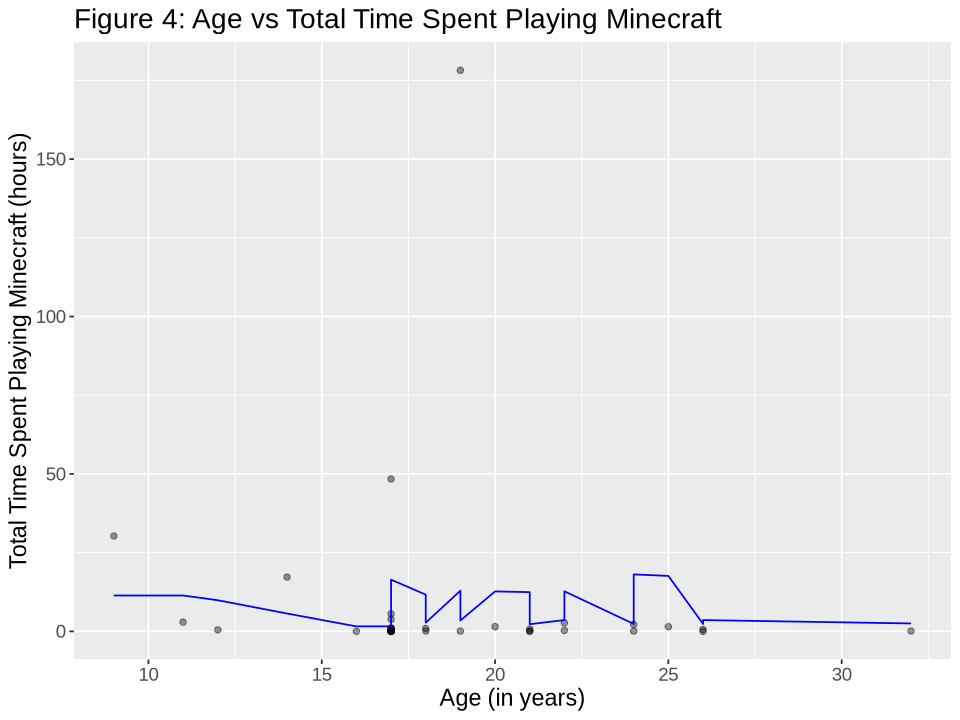

In [13]:
# plotting age vs played_hours
minecraft_age_plot <- minecraft_preds |>  
    ggplot(aes(x = Age, y = played_hours)) + #change x var
    geom_point(alpha = 0.4) +
    geom_line(aes(x = Age, y = .pred), col='blue') +
    labs(x = "Age (in years)", y = "Total Time Spent Playing Minecraft (hours)") +
    ggtitle("Figure 4: Age vs Total Time Spent Playing Minecraft") +
    theme(text = element_text(size = 14)) 
minecraft_age_plot

**Figure 5: Scatterplot of Average Playing Session Time vs Total Time Spent Playing Minecraft with the Regression Curve (Predicted Values) as a Blue Line**

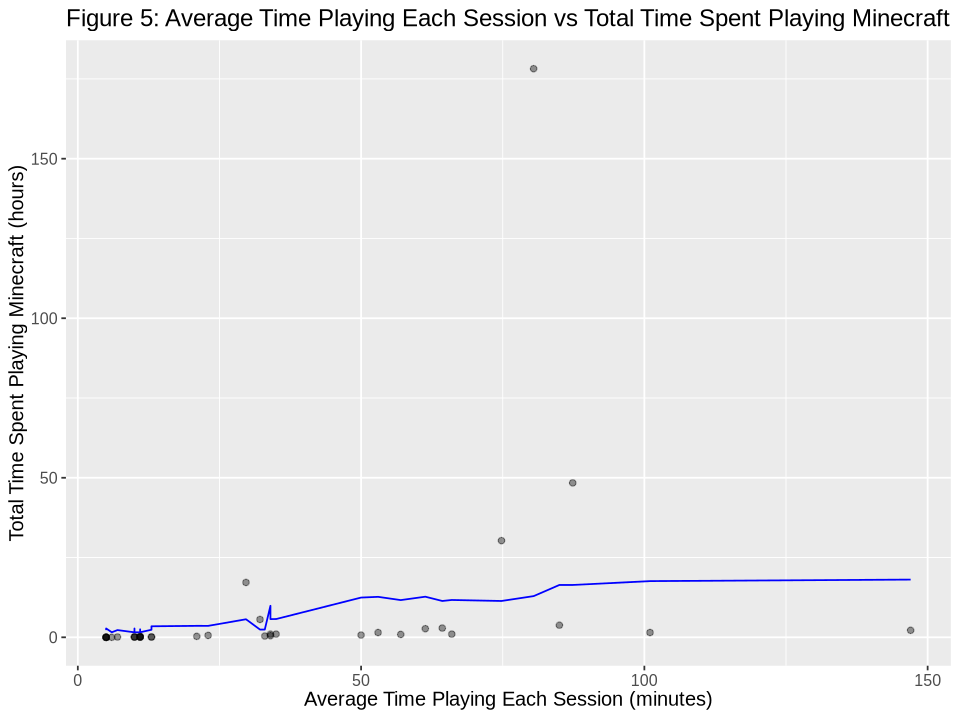

In [14]:
# plotting average session time vs played_hours
minecraft_session_time_plot <- minecraft_preds |>  
    ggplot(aes(x = session_average, y = played_hours)) + #change x var
    geom_point(alpha = 0.4) +
    geom_line(aes(x = session_average, y = .pred), col='blue') +
    labs(x = "Average Time Playing Each Session (minutes)", y = "Total Time Spent Playing Minecraft (hours)") +
    ggtitle("Figure 5: Average Time Playing Each Session vs Total Time Spent Playing Minecraft") +
    theme(text = element_text(size = 12)) 
minecraft_session_time_plot

<h3> Discussion </h3>

The K-nn regression that we performed used the two predictor variables age and the average time each player played Minecract for during each session to predict the total time spent playing Minecraft. It was initially predicted that there would be a relationship between the predictors and the response since younger participants may be more likely to play Minecraft and longer average session times could lead to a higher total time spent playing Minecraft. The exploratory visualizations showed no clear relationship between either predictor and the response variable, and no clear relationship between the predictors themselves. It was expected, based on the exploratory visualizations, that there would be either no relationship, or a weak relationship, between the predictor variables and the outcome. The predictive model we created found that the K value generating the lowest RMSE was 46, which is quite high, indicating the potential of underfitting. The reported RMSPE was also quite high at about 28.7 hours, implying that the model failed to predict the total time spent playing Minecraft accurately based on the specified predictors. <p> It should be noted that there were a small number of total playing times that were irregularily high, which likely contributed to the high RMSPE (the highest value  on the testing set was about 200 hours while the remainder of the values were all under 50 hours). The summary statistics show that the maximum value for total time spent playing Minecraft (on the training set) was 223.100 hours while the third quartile was only 0.600 hours. Perhaps, if there were no outliers, the RMSPE would have been lower. Figures 4 and 5 can also be considered when evaluating the effectiveness of the predictive model. Figure 4 shows that some of the points did end up on the regression curve, but that the curve adopts a peculiar shape and that several of the points are not on the curve. Figure 5 has a smoother regression curve but very few points are actually on the curve, indicating a low predicting accuracy. The unevenness or discrepancies between the two visualizations, along with the high K value and RMSPE, indicate that the selected predictors are unable to accurately predict the total time each player spent playing Minecraft. Due to the lack of success in establishing a predictive model, the findings from this analysis only indicate that age and player experience are poor predictors for the total time spent playing Minecraft, although if anything, age would likely be a better predictor than the average playing session time. </p> The analysis could indicate that other predictors, such as player experience, could potentially act as better predictors for the total time spent playing Minecraft. Perhaps the same analysis could be performed but after filtering the total played hours to be around the mean of 8.002 hours (such as from 0 to 10 hours for example) and running the predictive model again as this could yield better predictions or a lower RMSPE. Future questions or investigations could analyze similar situations to determine whether other variables serve as better predictors for the total time spent playing Minecraft. It would also be interesting to analyze predicted total playing time and the playing style of each player to see if there is a relationship between the two variables (assuming a better predictive model for total playing time is established), since it was mentioned that data on playing style was collected.